In [4]:
import os 
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
   multiprocessing.cpu_count()
)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tinygp 
from models import multiband
from transit import transit_with_trend

In [5]:
import h5py
import numpy as np

prefix = '/Users/tylergordon/research/TOI175.01/output/'
seg001_nrs1_dir = 'seg001_nrs1/Stage4/S4_2024-01-30_TOI175_run1/ap5_bg8/'
seg002_nrs1_dir = 'seg002_nrs1/Stage4/S4_2024-01-31_TOI175_run2/ap5_bg8/'
seg001_nrs2_dir = 'seg001_nrs2/Stage4/S4_2024-01-30_TOI175_run1/ap5_bg8/'
seg002_nrs2_dir = 'seg002_nrs2/Stage4/S4_2024-01-30_TOI175_run2/ap5_bg8/'

specfile = 'S4_TOI175_ap5_bg8_SpecData.h5'
lcfile = 'S4_TOI175_ap5_bg8_LCData.h5'

spec_001_1 = h5py.File(prefix + seg001_nrs1_dir + specfile, 'r')
lc_001_1 = h5py.File(prefix + seg001_nrs1_dir + lcfile, 'r')
spec_001_2 = h5py.File(prefix + seg001_nrs2_dir + specfile, 'r')
lc_001_2 = h5py.File(prefix + seg001_nrs2_dir + lcfile, 'r')
spec_002_1 = h5py.File(prefix + seg002_nrs1_dir + specfile, 'r')
lc_002_1 = h5py.File(prefix + seg002_nrs1_dir + lcfile, 'r')
spec_002_2 = h5py.File(prefix + seg002_nrs2_dir + specfile, 'r')
lc_002_2 = h5py.File(prefix + seg002_nrs2_dir + lcfile, 'r')

wav_nrs1 = np.array(spec_002_1['wave_1d'])
wav_nrs2 = np.array(spec_002_2['wave_1d'])

spec_nrs1 = np.concatenate([np.array(spec_001_1['optspec']), np.array(spec_002_1['optspec'])], axis=0)
spec_nrs2 = np.concatenate([np.array(spec_001_2['optspec']), np.array(spec_002_2['optspec'])], axis=0)

ypos_nrs1 = np.concatenate([np.array(lc_001_1['centroid_y']), np.array(lc_002_1['centroid_y'])], axis=0)
ypos_nrs2 = np.concatenate([np.array(lc_001_2['centroid_y']), np.array(lc_002_2['centroid_y'])], axis=0)

# there's one weirdly noisy wavelength so let's get rid of that 
bad_id = np.argmax(np.std(spec_nrs1, axis=0))
spec_nrs1 = np.delete(spec_nrs1, bad_id, axis=1)
wav_nrs1 = np.delete(wav_nrs1, bad_id)

time = np.concatenate([np.array(spec_001_1['time']), np.array(spec_002_1['time'])])

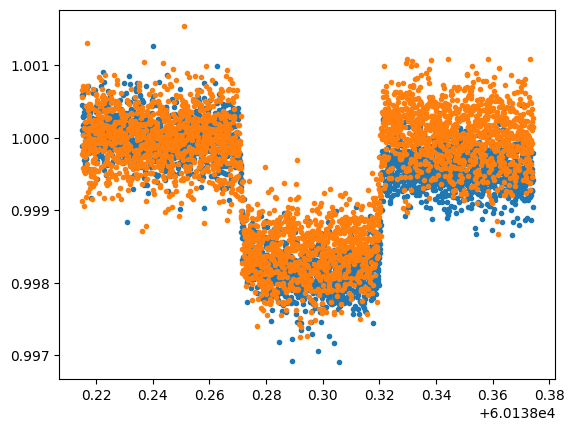

In [6]:
nrs1_white_light = np.sum(spec_nrs1, axis=1)
nrs2_white_light = np.sum(spec_nrs2, axis=1)

nrs1_norm = nrs1_white_light / np.median(nrs1_white_light[:1000])
nrs2_norm = nrs2_white_light / np.median(nrs2_white_light[:1000])

data = jnp.array([nrs1_norm, nrs2_norm])
t = time
plt.plot(t, data.T, '.');

In [7]:
term = lambda log_omega, log_sigma: tinygp.kernels.quasisep.SHO(
    omega=jnp.exp(log_omega), sigma=jnp.exp(log_sigma), quality=1/np.sqrt(2)
)
mean = lambda t, f0, m, q1, q2, r2, d, t0, b0: transit_with_trend(t, f0, m, 20.0, q1, q2, r2, d, t0, b0)

model = multiband(
    t - t[0],
    len(data),
    term,
    mean,
    constant_params = ['q1', 'q2']
)

lp = model.get_logp(data)
sampler = model.get_sampler()

noise:log_omega : 5.0
noise:log_sigma : -10.0
noise:a[0] : 0.5
noise:log_diag[0] : -16.469518661499023
noise:log_diag[1] : -15.616750717163086
mean:f0[0] : 1.000082015991211
mean:f0[1] : 0.9999428987503052
mean:m[0] : -0.0039138044230639935
mean:m[1] : 0.0006441859877668321
mean:q1 : 0.009999999776482582
mean:q2 : 0.019999999552965164
mean:r2[0] : 0.001521000056527555
mean:r2[1] : 0.001521000056527555
mean:d[0] : 0.05119999870657921
mean:d[1] : 0.05119999870657921
mean:t0[0] : 0.08079999685287476
mean:t0[1] : 0.08079999685287476
mean:b0[0] : 0.009999999776482582
mean:b0[1] : 0.009999999776482582
40127.086


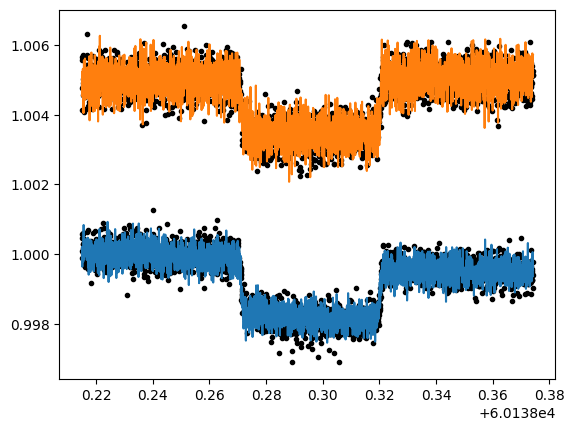

In [8]:
oot_length = 100
nbands = len(data)

f0 = [np.mean(d[:oot_length]) for d in data]
m0 = [(np.mean(d[-oot_length:]) - np.mean(d[:oot_length])) / (t[-1] - t[0]) for d in data]
ld = [0.01, 0.02]
r2 = [0.039**2] * nbands
dur_t0_b = [0.0512, 0.0512, 0.0808, 0.0808, 0.01, 0.01]
gp_params = [5, -10]
log_var = [np.log(np.var(d[:oot_length])) for d in data]
amps = [0.5] * (nbands - 1)

p = jnp.array(gp_params + amps + log_var + f0 + m0 + ld + r2 + dur_t0_b)
[print(pname, ": {0}".format(p)) for pname, p in zip(model.param_names, p)]
print(lp(p))
sample = sampler(p)

for i in range(2):
    plt.plot(t, data[i] + 0.005 * i, 'k.')
    plt.plot(t, sample[i::2] + 0.005 * i)

In [13]:
from inference import window_adapt, run_inference
state, adapt_params = window_adapt(lp, p, 500)

In [ ]:
mcmc_states = run_inference(lp, state.position, 5000, adapt_params=adapt_params, progress=True)

In [ ]:
import corner
corner.corner(np.array(mcmc_states.position, labels=model.param_names);

In [ ]:
import models
import imp
imp.reload(models)

from models import multiband_independent
term = lambda log_omega, log_sigma: tinygp.kernels.quasisep.SHO(
    omega=jnp.exp(log_omega), sigma=jnp.exp(log_sigma), quality=1/np.sqrt(2)
)
mean = lambda t, f0, m, q1, q2, r2, d, t0, b0: transit_with_trend(t, f0, m, 20.0, q1, q2, r2, d, t0, b0)

model = multiband_independent(
    t - t[0],
    len(data),
    term,
    mean,
    hold = ['q1', 'q2', 'log_omega']
)

In [ ]:
oot_length = 100
nbands = len(data)

f0 = [np.mean(d[:oot_length]) for d in data]
m0 = [(np.mean(d[-oot_length:]) - np.mean(d[:oot_length])) / (t[-1] - t[0]) for d in data]
ld = [0.01, 0.8]
r2 = [0.039**2] * nbands
dur_t0_b = [0.0512, 0.0512, 0.0808, 0.0808, 0.01, 0.01]
gp_params = [5, -10]
log_var = [np.log(np.var(d[:oot_length])) for d in data]

p = jnp.array([5] + [-10.0] * 2 + log_var + f0 + m0 + ld + r2 + dur_t0_b)
lp = model.get_logp(data)
[print(pname, ": {0}".format(p)) for pname, p in zip(model.param_names, p)]
print(lp(p))
sample = sampler(p, seed=1)

for i in range(2):
    plt.plot(t, data[i] + 0.005 * i, 'k.')
    plt.plot(t, sample[i::2] + 0.005 * i)

In [ ]:
state, adapt_params = window_adapt(lp, p, 500)
mcmc_states_independent = run_inference(lp, state.position, 5000, adapt_params=adapt_params)

In [ ]:
import corner
corner.corner(np.array(mcmc_states_independent.position), labels=model.param_names);

In [6]:
import models
import imp
imp.reload(models)

from models import multiband_no_gp

mean = lambda t, f0, m, q1, q2, r2, d, t0, b0: transit_with_trend(t, f0, m, 20.0, q1, q2, r2, d, t0, b0)

model = multiband_no_gp(
    t - t[0],
    len(data),
    mean,
    constant_params = ['q1', 'q2']
)

oot_length = 100
nbands = len(data)

f0 = [np.mean(d[:oot_length]) for d in data]
m0 = [(np.mean(d[-oot_length:]) - np.mean(d[:oot_length])) / (t[-1] - t[0]) for d in data]
ld = [0.01, 0.8]
r2 = [0.039**2] * nbands
dur_t0_b = [0.0512, 0.0512, 0.0808, 0.0808, 0.01, 0.01]
log_var = [np.log(np.var(d[:oot_length])) for d in data]

p = jnp.array(log_var + f0 + m0 + ld + r2 + dur_t0_b)
lp = model.get_logp(data)
[print(pname, ": {0}".format(p)) for pname, p in zip(model.param_names, p)]
print(lp(p))

noise:log_diag[0] : -16.469518661499023
noise:log_diag[1] : -15.616750717163086
mean:f0[0] : 1.000082015991211
mean:f0[1] : 0.9999428987503052
mean:m[0] : -0.0039138044230639935
mean:m[1] : 0.0006441859877668321
mean:q1 : 0.009999999776482582
mean:q2 : 0.800000011920929
mean:r2[0] : 0.001521000056527555
mean:r2[1] : 0.001521000056527555
mean:d[0] : 0.05119999870657921
mean:d[1] : 0.05119999870657921
mean:t0[0] : 0.08079999685287476
mean:t0[1] : 0.08079999685287476
mean:b0[0] : 0.009999999776482582
mean:b0[1] : 0.009999999776482582
94379.984


In [ ]:
state, adapt_params = window_adapt(lp, p, 500)
mcmc_states_no_gp = run_inference(lp, state.position, 5000, adapt_params=adapt_params)

In [ ]:
model.param_names[8:16]

In [ ]:
labels = ['\n\ndepth\n', '\n\nduration\n', '\n\ntransit time\n', '\n\nimpact parameter\n']

fig = plt.figure()
plt.suptitle("Independent GP")
corner.corner(np.array(mcmc_states.position[2000:, 11:19][:, ::2]), 
              fig=fig, color='b');
corner.corner(np.array(mcmc_states.position[2000:, 11:19][:, 1::2]), 
              fig=fig, color='r', labels=labels);
plt.subplots_adjust(left=0.2,bottom=0.2)

plt.savefig('/Users/tylergordon/Desktop/nrs1_vs_nrs2_id_gp.pdf')


fig = plt.figure()
plt.suptitle('Multiband GP')
corner.corner(np.array(mcmc_states_independent.position[2000:, 11:19][:, ::2]), 
              fig=fig, color='b');
corner.corner(np.array(mcmc_states_independent.position[2000:, 11:19][:, 1::2]), 
              fig=fig, color='r', labels=labels);

plt.subplots_adjust(left=0.2,bottom=0.2)

plt.savefig('/Users/tylergordon/Desktop/nrs1_vs_nrs2_multi_gp.pdf')

fig = plt.figure()
plt.suptitle('No GP')
corner.corner(np.array(mcmc_states_no_gp.position[2000:, 8:16][:, ::2]), 
              fig=fig, color='b');
corner.corner(np.array(mcmc_states_no_gp.position[2000:, 8:16][:, 1::2]), 
              fig=fig, color='r', labels=labels);

plt.subplots_adjust(left=0.2,bottom=0.2)

plt.savefig('/Users/tylergordon/Desktop/nrs1_vs_nrs2_no_gp.pdf')

In [ ]:
labels = ['\n\ndepth\n', '\n\nduration\n', '\n\ntransit time\n', '\n\nimpact parameter\n']

fig = plt.figure()
plt.suptitle("NRS 1")
corner.corner(np.array(mcmc_states.position[2000:, 11:19][:, ::2]), 
              fig=fig, color='b');
corner.corner(np.array(mcmc_states_independent.position[2000:, 11:19][:, ::2]), 
              fig=fig, color='r');
corner.corner(np.array(mcmc_states_no_gp.position[2000:, 8:16][:, ::2]), 
              fig=fig, color='g', labels=labels);
plt.subplots_adjust(left=0.2,bottom=0.2)

plt.savefig('/Users/tylergordon/Desktop/comparison_nrs1.pdf')


fig = plt.figure()
plt.suptitle('NRS 2')
corner.corner(np.array(mcmc_states_independent.position[2000:, 11:19][:, 1::2]), 
              fig=fig, color='b');
corner.corner(np.array(mcmc_states.position[2000:, 11:19][:, 1::2]), 
              fig=fig, color='r');
corner.corner(np.array(mcmc_states_no_gp.position[2000:, 8:16][:, 1::2]), 
              fig=fig, color='g', labels=labels);

plt.savefig('/Users/tylergordon/Desktop/comparison_nrs2.pdf')

plt.subplots_adjust(left=0.2,bottom=0.2)

In [ ]:
mean_func = model.mean_builder()

nsamps = 100

plt.figure(figsize=(20, 30))
plt.plot(t, data[0] + 0.005, 'k.', alpha=0.3)
plt.plot(t, data[1], 'k.', alpha=0.3)

inds = np.random.randint(3000, size=nsamps)

samps = [mcmc_states_independent.position[2000:, 5:][i] for i in inds]
[plt.plot(t, mean_func(s)[0][0] + 0.005, color='r', alpha=0.3) for s in samps];
[plt.plot(t, mean_func(s)[1][0], color='r', alpha=0.3) for s in samps];

samps = [mcmc_states.position[2000:, 5:][i] for i in inds]
[plt.plot(t, mean_func(s)[0][0] + 0.005, color='b', alpha=0.3) for s in samps];
[plt.plot(t, mean_func(s)[1][0], color='b', alpha=0.3) for s in samps];

samps = [mcmc_states_no_gp.position[2000:, 2:][i] for i in inds]
[plt.plot(t, mean_func(s)[0][0] + 0.005, color='g', alpha=0.3) for s in samps];
[plt.plot(t, mean_func(s)[1][0], color='g', alpha=0.3) for s in samps];

plt.savefig('/Users/tylergordon/Desktop/lc_withsamps.pdf')